In [ ]:
# !pip install pyts

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from pyts.transformation import ShapeletTransform
from pyts.transformation import BOSS
from pyts.classification import SAXVSM

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,balanced_accuracy_score
from sklearn.preprocessing import StandardScaler

In [4]:
# read text file into pandas DataFrame
train = pd.read_fwf("/Users/marie-noellepage/Documents/Formation/McGill/2. Applied Artificial Intelligence/4. Time Series Analysis Fundamentals/Course 2/ItalyPowerDemand_TRAIN.txt",header=None)
test = pd.read_fwf("/Users/marie-noellepage/Documents/Formation/McGill/2. Applied Artificial Intelligence/4. Time Series Analysis Fundamentals/Course 2/ItalyPowerDemand_TEST.txt",header=None)
  
print(train.shape)
print(test.shape)

(67, 25)
(1029, 25)


## Preprocess

In [5]:
# Data balanced
train.iloc[:,:1].value_counts()

1.0    34
2.0    33
dtype: int64

In [6]:
# Data balanced
test.iloc[:,:1].value_counts()

2.0    516
1.0    513
dtype: int64

The first column represents the target, the rest is one feature over the course of 24 days. The task then is to correctly classify, whether this month is in winter or in summer.

In [7]:
Y_train = train.iloc[:, 0]
Y_test = test.iloc[:, 0]
X_train = train.iloc[:, 1:]
X_test = test.iloc[:, 1:]

print(Y_train.shape, Y_test.shape)
print(X_train.shape, X_test.shape)

(67,) (1029,)
(67, 24) (1029, 24)


In [8]:
X_train.apply(pd.DataFrame.describe, axis=1)

,count,mean,std,min,25%,50%,75%,max
0,24.0,-1.041667e-09,1.0,-1.593083,-0.805078,0.030207,0.936412,1.464375
1,24.0,-1.958333e-09,1.0,-1.630917,-0.999388,0.384871,0.735720,1.201393
2,24.0,-1.775000e-09,1.0,-1.397118,-0.741487,-0.132687,0.265374,2.349344
3,24.0,-8.541667e-10,1.0,-1.646458,-0.898722,0.266022,0.776495,1.344487
4,24.0,-3.416667e-09,1.0,-1.620240,-0.978061,0.405495,0.692648,1.303502
...,...,...,...,...,...,...,...,...
62,24.0,-3.383333e-09,1.0,-1.613336,-1.043923,0.352636,0.742235,1.215746
63,24.0,-5.958333e-10,1.0,-1.752948,-0.929158,0.086211,0.871685,1.312316
64,24.0,-1.125000e-09,1.0,-1.606217,-1.098189,0.456379,0.745955,1.177780
65,24.0,-1.875000e-09,1.0,-1.506285,-1.021719,0.184060,0.792584,1.378570


In [9]:
train_1 = train[train.iloc[:, 0]==1].T
train_2 = train[train.iloc[:, 0]==2].T
train_2.head()

,2,3,6,9,10,13,15,18,21,27,...,51,52,53,55,56,59,60,63,65,66
0,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
1,1.319067,-0.812444,0.087213,-0.756240,-0.509517,-0.874915,0.839670,-0.869584,-0.812868,-0.648466,...,-0.199345,-0.981614,0.298284,-0.953237,-0.829040,1.209007,-0.815954,-0.373579,-0.694919,0.984033
2,0.569774,-1.157553,-0.576455,-1.188377,-1.239571,-1.265316,-0.369455,-1.226103,-1.172714,-1.094721,...,-0.705915,-1.342207,-0.518072,-1.621199,-1.194379,0.570286,-1.080588,-0.986632,-1.235829,0.169661
3,0.195128,-1.416385,-1.086969,-1.315476,-1.239571,-1.488402,-0.427032,-1.418074,-1.506857,-1.373631,...,-1.212484,-1.534523,-1.083242,-1.370714,-1.503513,-0.250926,-1.345222,-1.446422,-1.416133,-0.519423
4,-0.085856,-1.531421,-1.393278,-1.442575,-1.604599,-1.683602,-0.830074,-1.527772,-1.558264,-1.485195,...,-1.550198,-1.654721,-1.334429,-1.454209,-1.644028,-0.342172,-1.433433,-1.676316,-1.506285,-0.832643


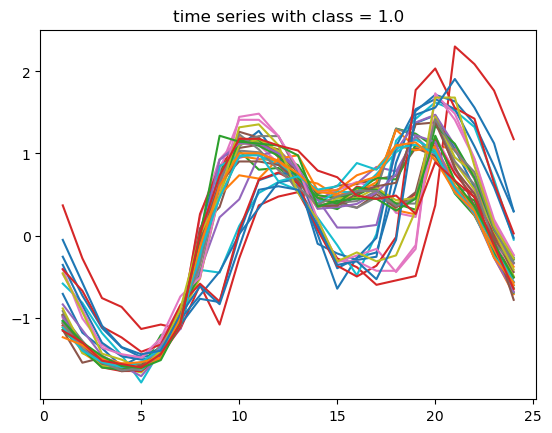

In [10]:
train_1.iloc[1:, :].plot.line(title=f'time series with class = {train_1.iloc[0, 0]}').get_legend().remove()

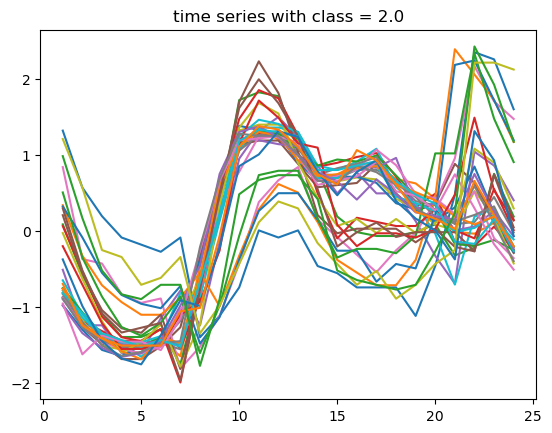

In [11]:
train_2.iloc[1:, :].plot.line(title=f'time series with class = {train_2.iloc[0, 0]}').get_legend().remove()

## Shapelet Transform

https://pyts.readthedocs.io/en/stable/generated/pyts.transformation.ShapeletTransform.html
https://pyts.readthedocs.io/en/stable/auto_examples/transformation/plot_shapelet_transform.html#

A shapelet is a subset of consecutive points from a time series. This algorithm extracts the most discriminative shapelets,  by returns the minimum distances between the shapelets, and all the shapelets of same length extracted from the time series. 

In [13]:
# Size of the sliding windows.
ws = [[2,6,10,14],[3,6,9,12],[2,3,5],[3,9],[6],[2,6,8,10],[2,4,6,8,10],[3,9,12],[2,5,8,12],[10,12,16,20],[2,6,8],[2,6]]

for i in ws:

    st = ShapeletTransform(random_state=0, n_shapelets=2, window_sizes=i)
    X_new = st.fit_transform(X_train, Y_train)
    X_test_trans = st.transform(X_test)
    #clf = LogisticRegression(random_state=0).fit(X_new ,Y_train)
    knn = KNeighborsClassifier().fit(X_new ,Y_train)
    preds = knn.predict(X_test_trans)
    print(round(balanced_accuracy_score(Y_test,preds),4), i)

0.9407 [2, 6, 10, 14]
0.9437 [3, 6, 9, 12]
0.7814 [2, 3, 5]
0.9251 [3, 9]
0.7873 [6]
0.9465 [2, 6, 8, 10]
0.9465 [2, 4, 6, 8, 10]
0.9437 [3, 9, 12]
0.9437 [2, 5, 8, 12]
0.9437 [10, 12, 16, 20]
0.8961 [2, 6, 8]
0.7873 [2, 6]


In [14]:
# The number of shapelets to keep.
ns = [1,2,3,4,5]

for i in ns:

    st = ShapeletTransform(n_shapelets=i, window_sizes=[2, 6, 8, 10])
    X_new = st.fit_transform(X_train, Y_train)
    X_test_trans = st.transform(X_test)
    #clf = LogisticRegression(random_state=0).fit(X_new ,Y_train)
    knn = KNeighborsClassifier().fit(X_new ,Y_train)
    preds = knn.predict(X_test_trans)
    print(round(balanced_accuracy_score(Y_test,preds),4), i)

0.9164 1
0.9465 2
0.9465 3
0.9456 4
0.9456 5


In [15]:
st = ShapeletTransform(n_shapelets=2, window_sizes=[2, 6, 8, 10])
X_new = st.fit_transform(X_train, Y_train)
X_test_trans = st.transform(X_test)
clf = LogisticRegression(random_state=0).fit(X_new ,Y_train)
preds = clf.predict(X_test_trans)
print(round(balanced_accuracy_score(Y_test,preds),4), 'Logistic Regression')

0.8785 Logistic Regression


In [16]:
st = ShapeletTransform(n_shapelets=2, window_sizes=[2, 6, 8, 10])
X_new = st.fit_transform(X_train, Y_train)
X_test_trans = st.transform(X_test)
clf = RandomForestClassifier(random_state=0).fit(X_new ,Y_train)
preds = clf.predict(X_test_trans)
print(round(balanced_accuracy_score(Y_test,preds),4), 'Random Forest Classifier')

0.9097 Random Forest Classifier


In [17]:
st = ShapeletTransform(n_shapelets=2, window_sizes=[2, 6, 8, 10])
X_new = st.fit_transform(X_train, Y_train)
X_test_trans = st.transform(X_test)
clf = SVC(random_state=0).fit(X_new ,Y_train)
preds = clf.predict(X_test_trans)
print(round(balanced_accuracy_score(Y_test,preds),4), 'SVC')

0.9504 SVC


In [18]:
# Regularization parameter. 
C = [0.1,0.4,0.5,0.6,0.9,1,1.1,5]

for i in C:
    st = ShapeletTransform(n_shapelets=2, window_sizes=[2, 6, 8, 10])
    X_new = st.fit_transform(X_train, Y_train)
    X_test_trans = st.transform(X_test)
    clf = SVC(random_state=0, C=i).fit(X_new ,Y_train)
    preds = clf.predict(X_test_trans)
    print(round(balanced_accuracy_score(Y_test,preds),4), i)

0.927 0.1
0.9514 0.4
0.9533 0.5
0.9523 0.6
0.9495 0.9
0.9504 1
0.9495 1.1
0.9369 5


In [19]:
# Specifies the kernel type to be used in the algorithm.
kernel = ['linear', 'poly', 'rbf', 'sigmoid']

for i in kernel:
    st = ShapeletTransform(n_shapelets=2, window_sizes=[2, 6, 8, 10])
    X_new = st.fit_transform(X_train, Y_train)
    X_test_trans = st.transform(X_test)
    clf = SVC(random_state=0,C=0.5, kernel=i).fit(X_new ,Y_train)
    preds = clf.predict(X_test_trans)
    print(round(balanced_accuracy_score(Y_test,preds),4), i)

0.8601 linear
0.9465 poly
0.9533 rbf
0.2622 sigmoid


In [20]:
# Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.
gamma = [8,10,12,14,16]

for i in gamma:
    st = ShapeletTransform(n_shapelets=2, window_sizes=[2, 6, 8, 10])
    X_new = st.fit_transform(X_train, Y_train)
    X_test_trans = st.transform(X_test)
    clf = SVC(random_state=0,C=0.5, kernel='rbf', gamma=i).fit(X_new ,Y_train)
    preds = clf.predict(X_test_trans)
    print(round(balanced_accuracy_score(Y_test,preds),4), i)

0.9514 8
0.9533 10
0.9543 12
0.9514 14
0.9504 16


2.0
1.0
1.0
1.0


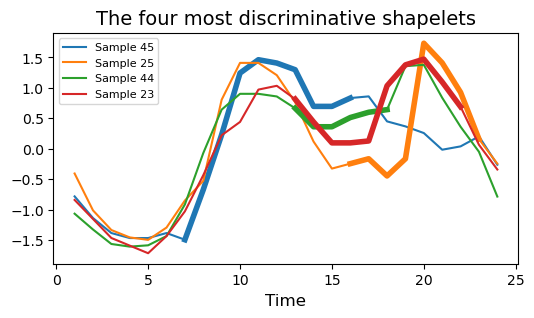

In [31]:
st = ShapeletTransform(n_shapelets=4, window_sizes=[2, 6, 8, 10])
X_new = st.fit_transform(X_train, Y_train)

plt.figure(figsize=(6, 3))
for i, index in enumerate(st.indices_[:4]):
    idx, start, end = index
    plt.plot(X_train.iloc[idx,:], color='C{}'.format(i), label='Sample {}'.format(idx))
    plt.plot(np.arange(start, end), X_train.iloc[idx, start-1:end-1], lw=4, color='C{}'.format(i))
    print (Y_train.iloc[idx])

plt.xlabel('Time', fontsize=12)
plt.title('The four most discriminative shapelets', fontsize=14)
plt.legend(loc='best', fontsize=8)
plt.show()

The graph illustrates the transformation of this algorithm and highlights the most discriminative shapelets that have been selected. We can see the time seris in blue has an other class than the 3 others.

## Symbolic Aggregate approXimation in Vector Space Model (SAX-VSM)

https://pyts.readthedocs.io/en/stable/generated/pyts.classification.SAXVSM.html
https://pyts.readthedocs.io/en/stable/auto_examples/classification/plot_saxvsm.html

The time series are first transformed into bag of word using the SAX algorithm. Then the classes are transformed into a vector space model using the tf-idf.

In [23]:
clf = SAXVSM(window_size=24, word_size=12, n_bins=5, strategy='normal')
clf.fit(X_train, Y_train)
round(clf.score(X_test, Y_test),4)

0.6142

In [24]:
# Length of the sliding window.
ws = [0.5,0.6,0.65,0.75,0.77,0.8]
#ws = [12,24]

for i in ws:
    clf = SAXVSM(window_size=i, word_size=12, n_bins=5, strategy='normal')
    clf.fit(X_train, Y_train)
    print(round(clf.score(X_test, Y_test),4),i)

0.7541 0.5
0.7949 0.6
0.7493 0.65
0.828 0.75
0.8134 0.77
0.794 0.8


In [25]:
# Length of the words.
ws = [2,3,4,5,6,7,8,12]

for i in ws:
    clf = SAXVSM(window_size=0.75, word_size=i, n_bins=5, strategy='normal')
    clf.fit(X_train, Y_train)
    print(round(clf.score(X_test, Y_test),4),i)

0.5627 2
0.828 3
0.863 4
0.8989 5
0.8882 6
0.9057 7
0.898 8
0.828 12


In [26]:
# The number of bins to produce.
nb = [2,3,4,5,6,7,12]

for i in nb:
    clf = SAXVSM(window_size=0.75, word_size=7, n_bins=i, strategy='normal')
    clf.fit(X_train, Y_train)
    print(round(clf.score(X_test, Y_test),4),i)

0.862 2
0.9125 3
0.9135 4
0.9057 5
0.863 6
0.8406 7
0.7784 12


In [27]:
# Strategy used to define the widths of the bins:
# ‘uniform’: All bins in each sample have identical widths
# ‘quantile’: All bins in each sample have the same number of points
# ‘normal’: Bin edges are quantiles from a standard normal distribution

s = ['uniform', 'quantile', 'normal']

for i in s:
    clf = SAXVSM(window_size=0.75, word_size=7, n_bins=4, strategy=i)
    clf.fit(X_train, Y_train)
    print(round(clf.score(X_test, Y_test),4),i)

0.9096 uniform
0.9291 quantile
0.9135 normal


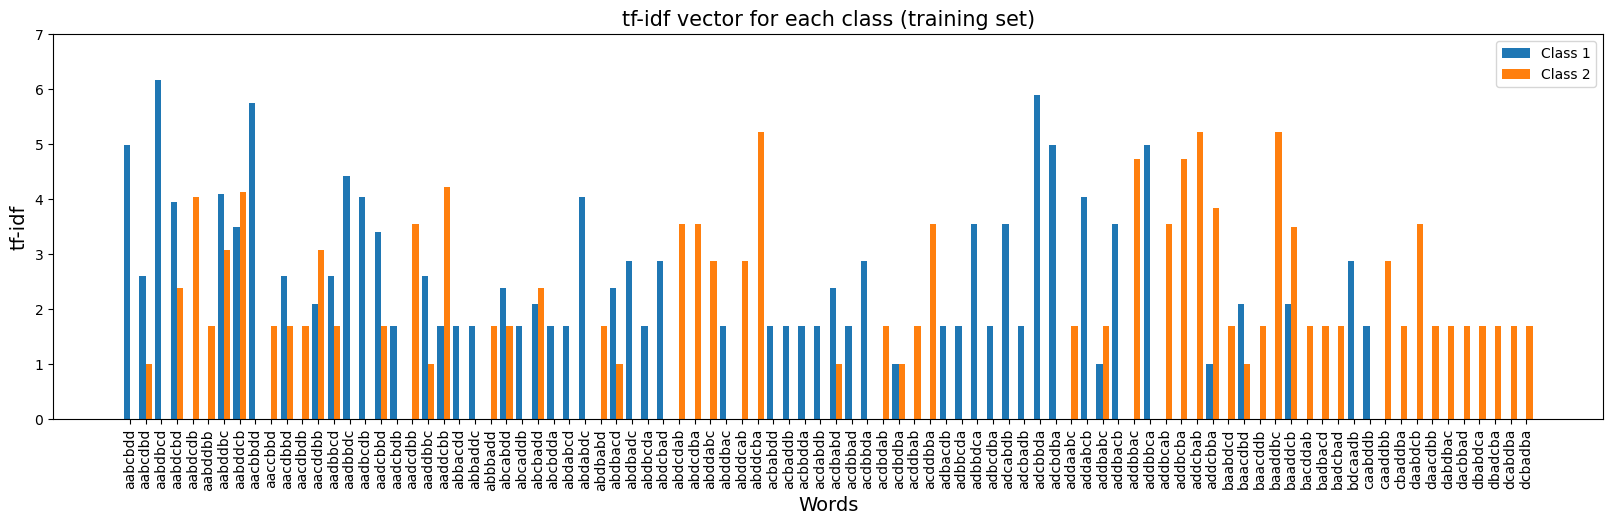

In [28]:
# SAXVSM transformation
saxvsm = SAXVSM(window_size=0.75, word_size=7, n_bins=4,
                strategy='quantile')
saxvsm.fit(X_train, Y_train)
tfidf = saxvsm.tfidf_
vocabulary_length = len(saxvsm.vocabulary_)
X_new = saxvsm.decision_function(X_test)

# Visualize the transformation
plt.figure(figsize=(20, 5))
width = 0.4

plt.bar(np.arange(vocabulary_length) - width / 2, tfidf[0],
        width=width, label='Class 1')
plt.bar(np.arange(vocabulary_length) + width / 2, tfidf[1],
        width=width, label='Class 2')
plt.xticks(np.arange(vocabulary_length),
           np.vectorize(saxvsm.vocabulary_.get)(np.arange(vocabulary_length)),
           fontsize=14)
plt.ylim((0, 7))
plt.xlabel("Words", fontsize=14)
plt.xticks(rotation='vertical', fontsize=10)
plt.ylabel("tf-idf", fontsize=14)
plt.title("tf-idf vector for each class (training set)", fontsize=15)
plt.legend(loc='best')

You can see the representation of the transformation for the training set in the graph. Each class is represented as a tf-idf vector.

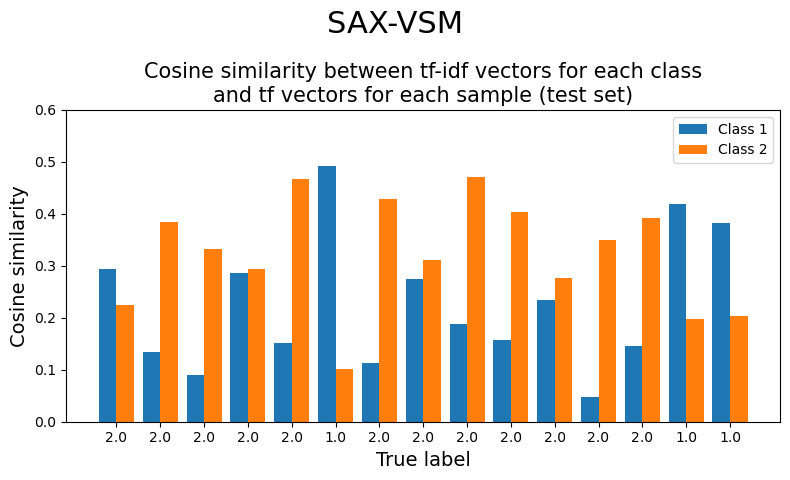

In [29]:
plt.figure(figsize=(8, 5))

n_samples_plot = 15
plt.bar(np.arange(n_samples_plot) - width / 2, X_new[:n_samples_plot, 0],
        width=width, label='Class 1')
plt.bar(np.arange(n_samples_plot) + width / 2, X_new[:n_samples_plot, 1],
        width=width, label='Class 2')
plt.xticks(np.arange(n_samples_plot), Y_test[:n_samples_plot])
plt.ylim((0, 0.6))
plt.xlabel("True label", fontsize=14)
plt.ylabel("Cosine similarity", fontsize=14)
plt.title(("Cosine similarity between tf-idf vectors for each class\n"
           "and tf vectors for each sample (test set)"), fontsize=15)
plt.legend(loc='best')

plt.suptitle("SAX-VSM", y=0.95, fontsize=22)
plt.tight_layout()
plt.subplots_adjust(top=0.75)
plt.show()

The second graph represent the prediction of the label giving the highest cosine similarity. We can see that the first time series is wrong. The highest cosine similarity corresponds to the first class, but the true label corresponds to the second class.